Building an effective Point Spread Function (ePSF) on M67
==================================================

*adapted from the Photutils tutorial!*


The ePSF
--------

The instrumental PSF is a combination of many factors that are
generally difficult to model.  `Anderson and King (2000; PASP 112,
1360) <http://adsabs.harvard.edu/abs/2000PASP..112.1360A>`_ showed
that accurate stellar photometry and astrometry can be derived by
modeling the net PSF, which they call the effective PSF (ePSF).  The
ePSF is an empirical model describing what fraction of a star's light
will land in a particular pixel.  The constructed ePSF is typically
oversampled with respect to the detector pixels.


Building an ePSF
----------------

Photutils provides tools for building an ePSF following the
prescription of `Anderson and King (2000; PASP 112, 1360)
<http://adsabs.harvard.edu/abs/2000PASP..112.1360A>`_ The process
involves iterating between the ePSF itself and the stars used to build
it.

To begin, we must first define a sample of stars used to build the
ePSF.  Ideally these stars should be bright (high S/N) and isolated to
prevent contamination from nearby stars.  One may use the star-finding
tools in Photutils (e.g.  :class:`~photutils.detection.DAOStarFinder`
or :class:`~photutils.detection.IRAFStarFinder`) to identify an
initial sample of stars.  However, the step of creating a good sample
of stars will also likely require visual inspection and manual
selection to ensure stars are sufficiently isolated and of good
quality (e.g. no cosmic rays, detector artifacts, etc.).


In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import lightkurve
from tqdm import tqdm_notebook as tqdm

from astropy.io import fits

Read in the M67 data cube:

In [2]:
df_targs = pd.read_csv('https://keplerscience.arc.nasa.gov/data/campaigns/c16/K2Campaign16targets.csv')
M67_ids = df_targs[' Investigation IDs'].str.contains('M67')
df_M67 = df_targs[M67_ids].reset_index(drop=True)
df_M67['fn'] = df_M67['EPIC ID'].apply(lambda x:"ktwo{}-c16_lc/ktwo{}-c16_lpd-targ.fits.gz".format(x,x))

In [3]:
tpf = lightkurve.KeplerTargetPixelFile('mastDownload/K2/'+df_M67.fn[167])
ncad, dx, dy = tpf.shape

In [4]:
empty_frame = np.zeros((1024, 1024))
empty_cube = np.zeros((ncad, 1024, 1024))
for loc in tqdm(df_M67.index.values):
    tpf_local = lightkurve.KeplerTargetPixelFile('mastDownload/K2/'+df_M67.fn[loc])
    x0, y0 = tpf_local.column, tpf_local.row
    ncad, dx, dy = tpf_local.shape
    empty_frame[x0:x0+dx, y0:y0+dy] = tpf_local.flux[100,:,:].T
    empty_cube[:, y0:y0+dy, x0:x0+dx] = tpf_local.flux[:,:,:]

Trim the cube to just the data area.  This takes a minute...

In [5]:
%%time
bad_mask = np.all(empty_cube==0, axis=0)

CPU times: user 9.95 s, sys: 21 s, total: 30.9 s
Wall time: 34.4 s


In [6]:
empty_cube.shape

(3645, 1024, 1024)

In [9]:
new_mask = bad_mask[np.newaxis, :, :]
new_mask.shape

(1, 1024, 1024)

In [22]:
nu_mask = np.repeat(new_mask, 3645, axis=0)

In [41]:
xcut = np.where(bad_mask[:, 500]==0)
x_min, x_max = np.min(xcut), np.max(xcut)
ycut = np.where(bad_mask[200, :]==0)
y_min, y_max = np.min(ycut), np.max(ycut)

In [42]:
%%time
m67_cube = empty_cube[:, x_min:x_max, y_min:y_max]

CPU times: user 506 µs, sys: 242 ms, total: 242 ms
Wall time: 241 ms


In [43]:
m67_cube.shape

(3645, 359, 399)

In [47]:
frame=1000
data = m67_cube[frame, :, :]

In [48]:
vlo, lo, medlo, med, hi, vhi = np.nanpercentile(data, (1,5,10,50,95,99))

In [49]:
vstep = (hi-lo)/300.0

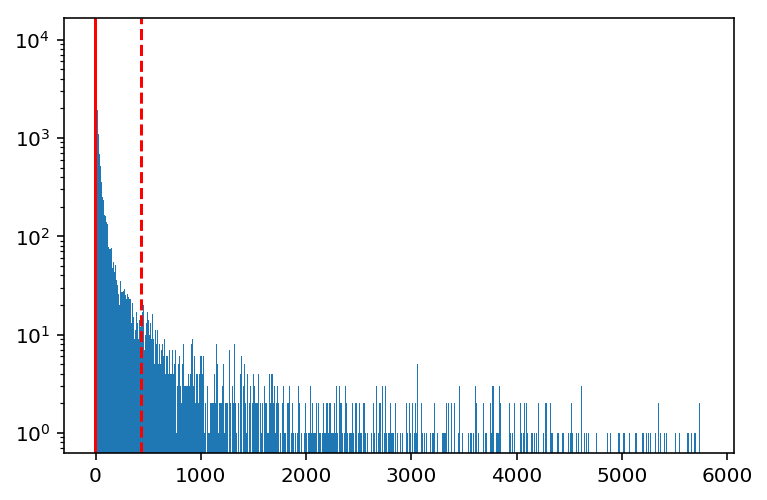

In [50]:
xbins = np.arange(vlo, vhi, vstep)
plt.hist(data.reshape(-1), bins=xbins)
plt.axvline(medlo, c='red')
plt.axvline(hi, c='red', linestyle='dashed')
plt.yscale('log')

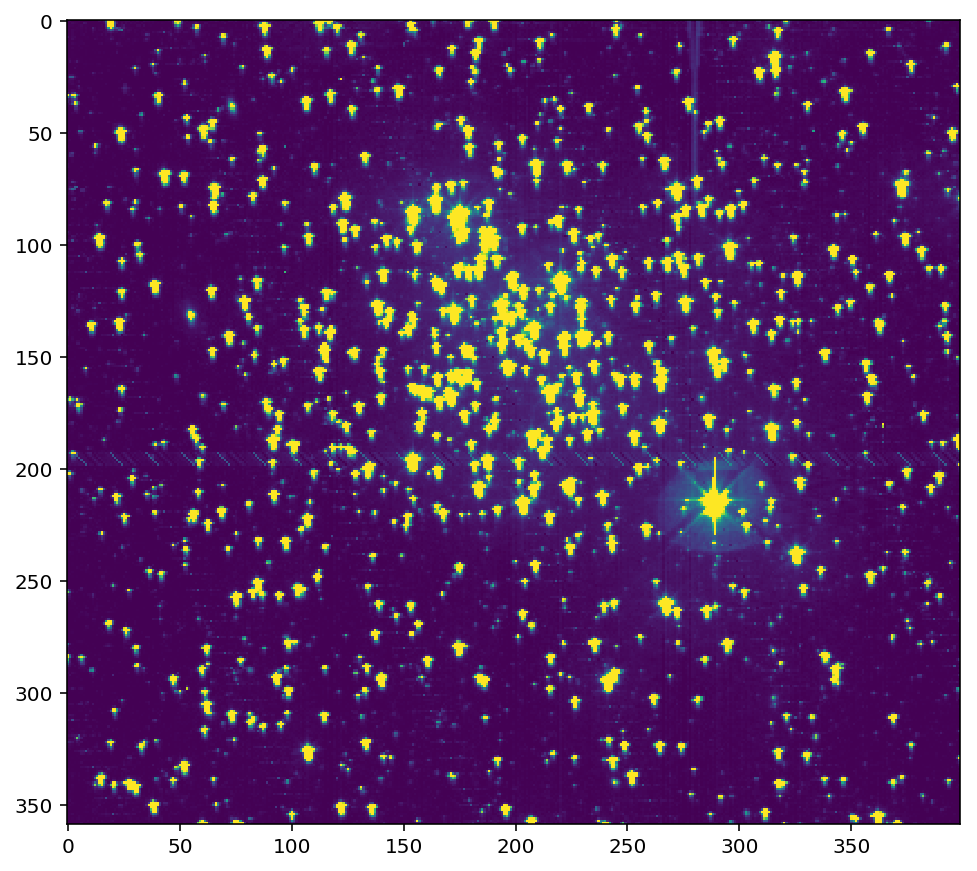

In [51]:
plt.figure(figsize=(8,8))
plt.imshow(data, vmin=medlo, vmax=hi)

Dramatic PSF!

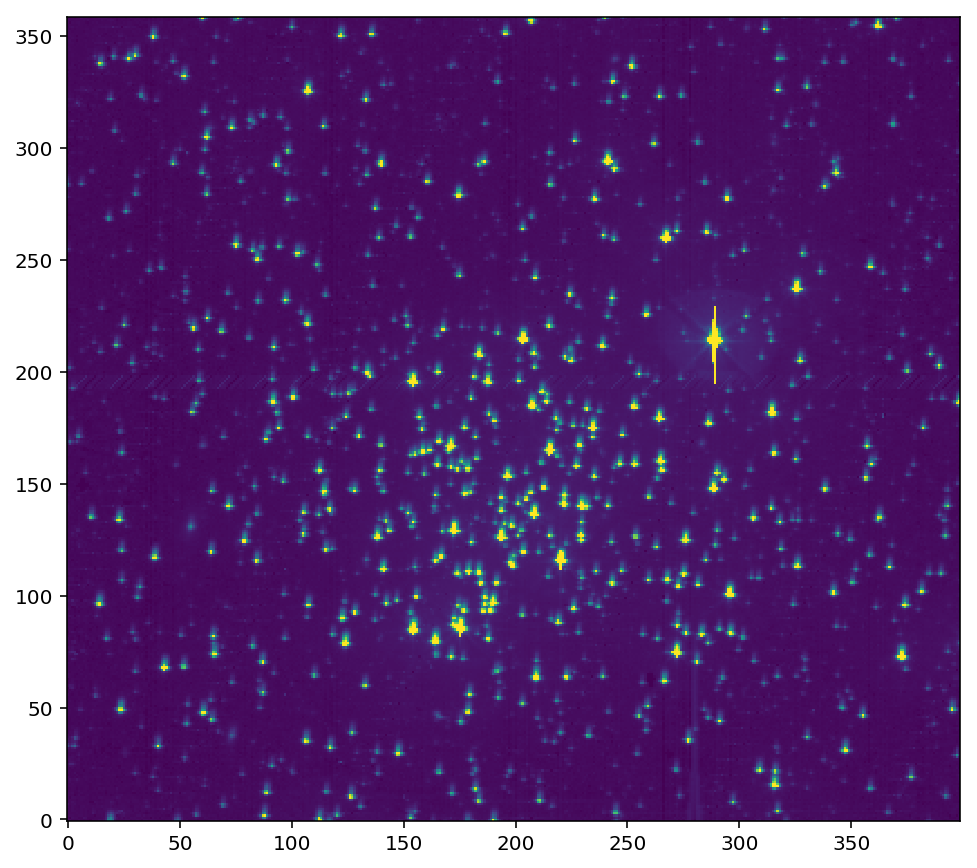

In [53]:
from astropy.visualization import simple_norm
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis');

For this example we'll use the :func:`~photutils.detection.find_peaks`
function to identify the stars and their initial positions.  We will
not use the centroiding option in
:func:`~photutils.detection.find_peaks` to simulate the effect of
having imperfect initial guesses for the positions of the stars.  Here we
set the detection threshold value to 500.0 to select only the brightest
stars:

In [54]:
from photutils import find_peaks
peaks_tbl = find_peaks(data, threshold=2000.)
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)

x_peak y_peak peak_value
------ ------ ----------
    19      0  2878.5916
   112      0  28898.076
   190      0  16646.762
   153      1  8164.3799
    88      2  14704.354
   120      2  6267.4839
   245      3  6650.4482
   317      4  10734.013
   131      6  2323.5713
   183      8  10544.188
   ...    ...        ...
   135    351   13044.21
   195    351  14998.275
   311    353  12242.276
   100    354  6124.5332
   362    354  92983.117
   352    356  2448.3364
   207    357   31365.32
    60    358  20458.947
    76    358  9141.8193
   240    358  9603.9619
   370    358  8347.6787
Length = 547 rows


Filter for isolated stars.

In [81]:
peaks_tbl['neighbor_dist'] = 9999

In [85]:
for i in range(547):
    dist_arr = np.sqrt(( (peaks_tbl['x_peak'][i] - peaks_tbl['x_peak'].data)**2 +
                 (peaks_tbl['y_peak'][i] - peaks_tbl['y_peak'].data)**2 ))
    peaks_tbl['neighbor_dist'][i] = np.min(dist_arr[dist_arr > 0])

In [87]:
peaks_tbl[0:5]

x_peak,y_peak,peak_value,neighbor_dist
int64,int64,float64,int64
19,0,2878.5916,39
112,0,28898.076,8
190,0,16646.762,10
153,1,8164.3799,21
88,2,14704.354,10


what's the distribution of neighbor distances?

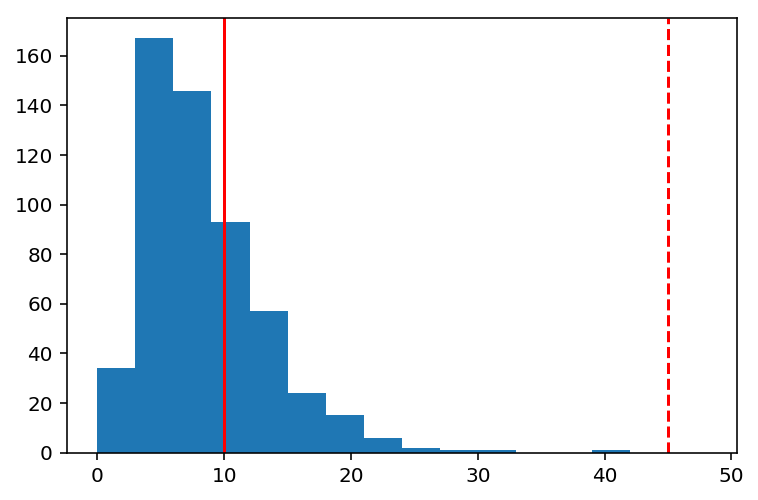

In [95]:
plt.hist(peaks_tbl['neighbor_dist'], bins=np.arange(0, 50, 3));
plt.axvline(10, c='red')
plt.axvline(45, c='red', linestyle='dashed')
plt.yscale('linear')
gi_mask1 = ( (peaks_tbl['neighbor_dist'] < 45) & (peaks_tbl['neighbor_dist'] > 10))

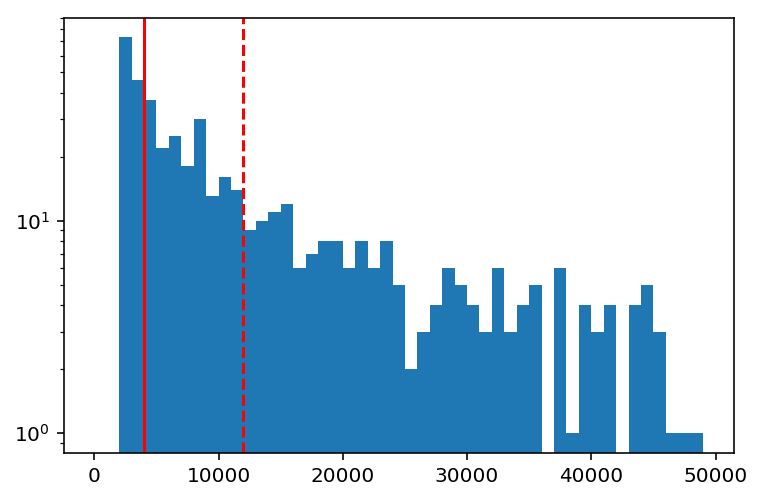

In [96]:
plt.hist(peaks_tbl['peak_value'], bins=np.arange(0, 50000, 1000));
plt.axvline(4000, c='red')
plt.axvline(12000, c='red', linestyle='dashed')
plt.yscale('log')
gi_mask2 = ( (peaks_tbl['peak_value'] < 12000) & (peaks_tbl['peak_value'] > 4000))

In [97]:
gi_mask = gi_mask1 & gi_mask2

Note that the stars are sufficiently separated in the simulated image
that we do not need to exclude any stars due to crowding.  In practice
this step will require some manual inspection and selection.

Next, we need to extract cutouts of the stars using the
:func:`~photutils.psf.extract_stars` function.  This function requires
a table of star positions either in pixel or sky coordinates.  For
this example we are using the pixel coordinates, which need to be in
table columns called simply ``x`` and ``y``.  Let's create that
table:

In [98]:
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = peaks_tbl['x_peak'][gi_mask]
stars_tbl['y'] = peaks_tbl['y_peak'][gi_mask]

The star cutouts from which we build the ePSF must have the background
subtracted.  Here we'll use the sigma-clipped median value as the
background level.  If the background in the image varies across the
image, one should use more sophisticated methods (e.g.
`~photutils.background.Background2D`).

Let's subtract the background from the image::

In [99]:
from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.,maxiters=None)
data -= median_val

The :func:`~photutils.psf.extract_stars` function requires the input
data as an `~astropy.nddata.NDData` object.  An
`~astropy.nddata.NDData` object is easy to create from our data
array::

In [100]:
from astropy.nddata import NDData
nddata = NDData(data=data)

We are now ready to create our star cutouts using the
:func:`~photutils.psf.extract_stars` function.  For this simple
example we are extracting stars from a single image using a single
catalog.  The :func:`~photutils.psf.extract_stars` can also extract
stars from multiple images using a separate catalog for each image or
a single catalog.  When using a single catalog, the star positions
must be in sky coordinates (as `~astropy.coordinates.SkyCoord`
objects) and the `~astropy.nddata.NDData` objects must contain valid
`~astropy.wcs.WCS` objects.  In the case of using multiple images
(i.e. dithered images) and a single catalog, the same physical star
will be "linked" across images, meaning it will be constrained to have
the same sky coordinate in each input image.

Let's extract 25 x 25 pixel cutouts of our selected stars:

In [138]:
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=11)

In [139]:
stars.n_good_stars, stars.n_stars

(44, 44)

They're all good stars.

The function returns a `~photutils.psf.Stars` object containing the
cutouts of our selected stars.  The function extracted 403 stars, from
which we'll build our ePSF.  Let's show the first 25 of them:

In [140]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Clean the identified stars:
- Stars that are too bright are saturated.
- Stars that are too faint are noisy.
- Stars with nearby neighbors are not isolated enough.

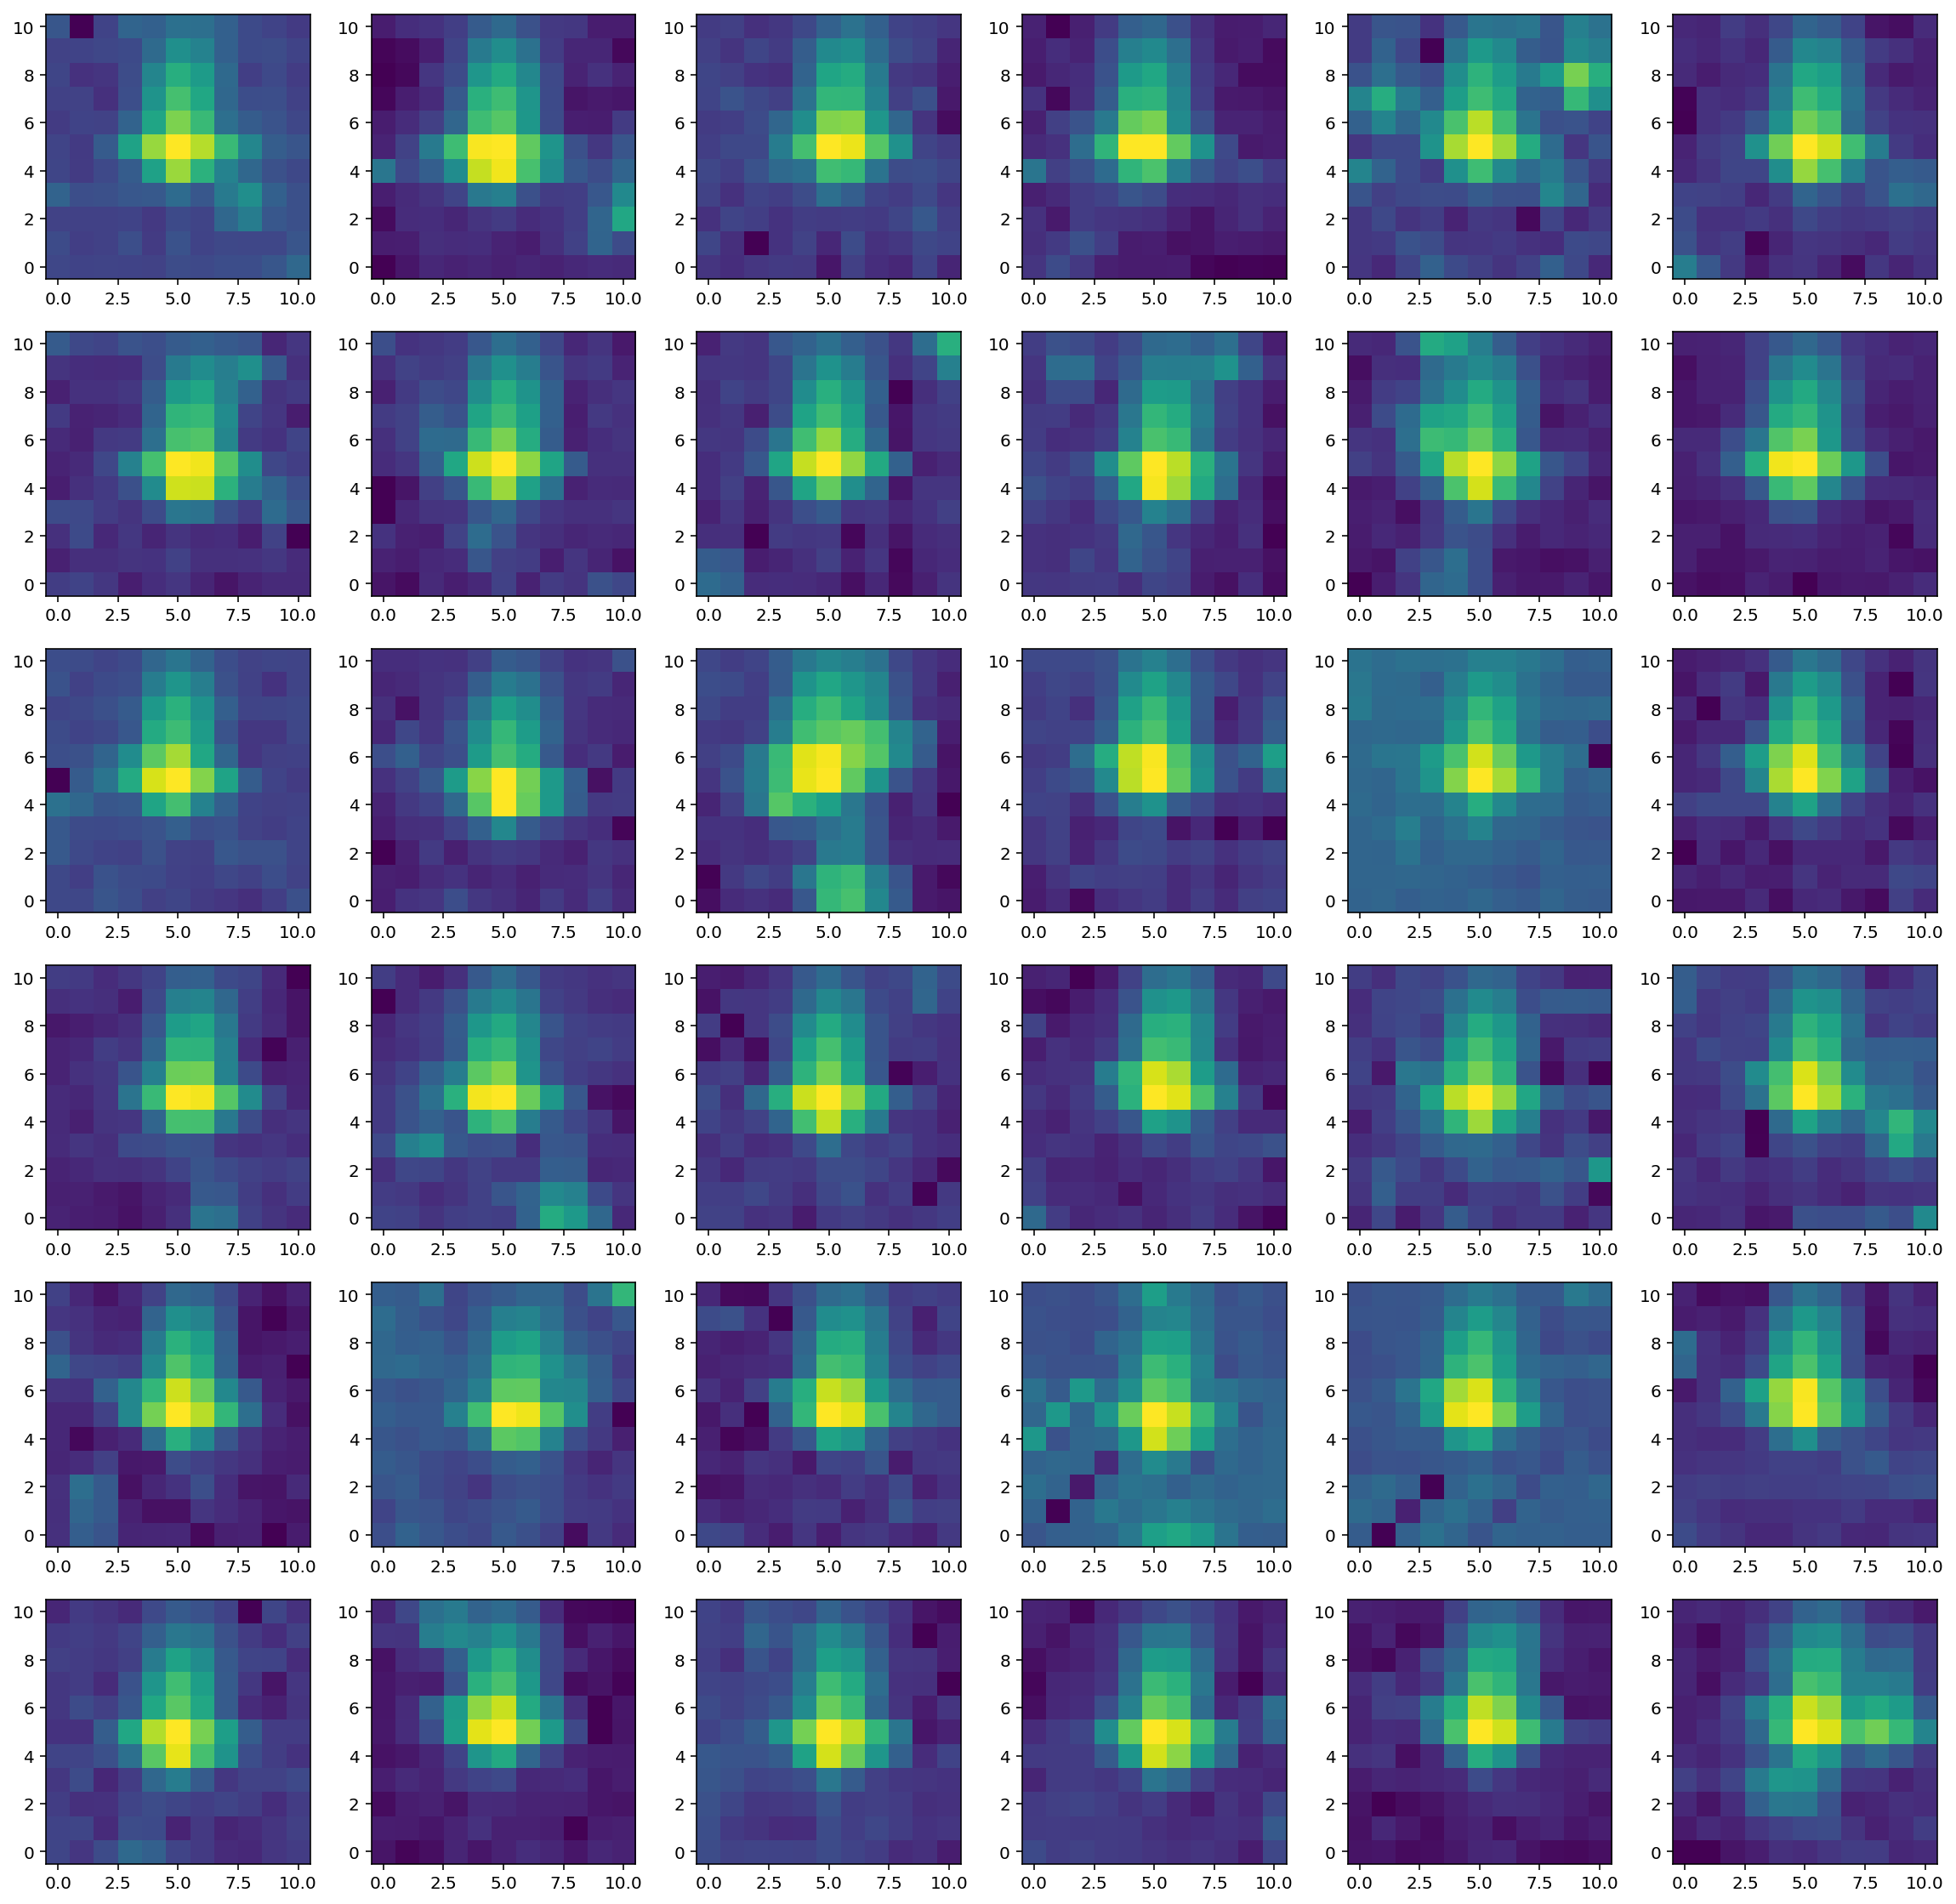

In [141]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 6
ncols = 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

With the star cutouts in hand, we are ready to construct the ePSF with
the :class:`~photutils.psf.EPSFBuilder` class.  We'll create an ePSF
with an oversampling factor of 4.0.  Here we limit the maximum number
of iterations to 3 (to limit it's run time), but in practice one
should use about 10 or more iterations.  The
:class:`~photutils.psf.EPSFBuilder` class has many other options to
control the ePSF build process, including changing the centering
function, the smoothing kernel, and the centering accuracy.  Please
see the :class:`~photutils.psf.EPSFBuilder` documentation for further
details.

We first initialize an :class:`~photutils.psf.EPSFBuilder` instance
with our desired parameters and then input the cutouts of our selected
stars to the instance:

In [142]:
from photutils import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=6, progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)

The returned values are the ePSF, as an
:class:`~photutils.psf.EPSFModel` object, and our input stars fitted
with the constructed ePSF, as a new :class:`~photutils.psf.Stars`
object with fitted star positions and fluxes.

Finally, let's show the constructed ePSF:

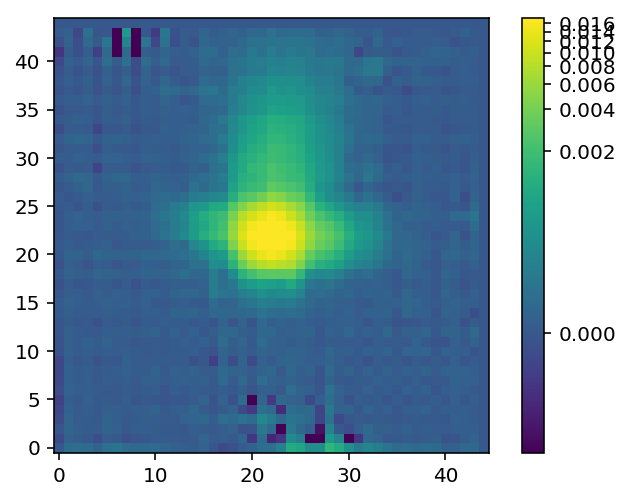

In [143]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

In [132]:
levels = np.nanpercentile(epsf.data, np.arange(93, 99.7, 0.2))

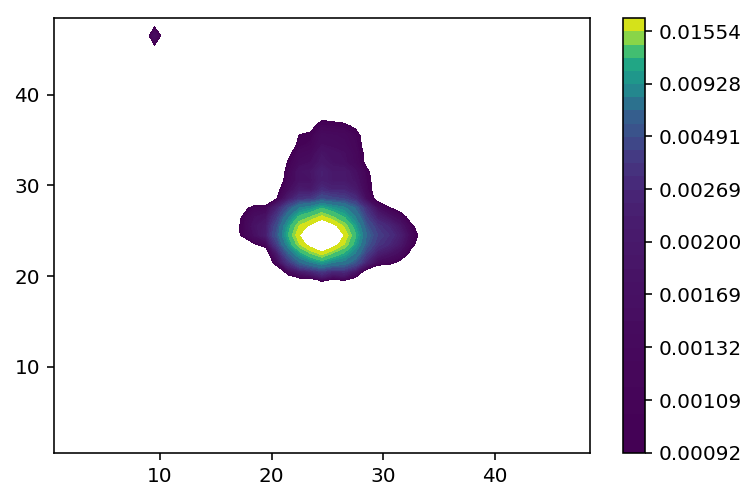

In [133]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(epsf.data, 'linear', percent=50.)
plt.contourf(epsf.data, levels=levels, origin='lower', cmap='viridis')
plt.colorbar()

The :class:`~photutils.psf.EPSFModel` object is a subclass of
:class:`~photutils.psf.FittableImageModel`, thus it can be used as a
the PSF model for the `PSF-fitting machinery in Photutils
<http://photutils.readthedocs.io/en/latest/psf.html>`_ (i.e.
`~photutils.psf.BasicPSFPhotometry`,
`~photutils.psf.IterativelySubtractedPSFPhotometry`, or
`~photutils.psf.DAOPhotPSFPhotometry`).

Neat...